In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2


from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [3]:
import tensorflow as tf
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
from ganime.model.vqgan_clean.experimental.net2net import Net2Net
import tensorflow_addons as tfa
from datetime import datetime
from tqdm import tqdm
from pyprojroot.pyprojroot import here

#tf.get_logger().setLevel('WARNING')
import warnings
warnings.filterwarnings('ignore')

2022-06-13 13:45:00.837026: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 13:45:03.673823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-06-13 13:45:03.675091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22308 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:25:00.0, compute capability: 8.6
2022-06-13 13:45:03.676015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/

In [5]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [6]:
cfg = omegaconf.OmegaConf.load(here("configs/moving_mnist_image_transformer_huggingface.yaml"))
#cfg = omegaconf.OmegaConf.load(here("configs/default_transformer.yaml"))
batch_size = cfg["train"]["batch_size"] 
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_epochs = cfg["train"]["n_epochs"]

In [7]:
dataset_length = 10000
num_batch = dataset_length / batch_size

In [8]:
def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

In [9]:
dataset = VideoDataset("../../../data/moving_mnist_tfrecords").load()
dataset = dataset.shuffle(dataset_length, reshuffle_each_iteration=True).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [10]:
train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

In [11]:
train_ds = dataset.take(train_size)#.batch(global_batch_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.batch(global_batch_size)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.batch(global_batch_size)

In [12]:
train_sample_data = next(train_ds.batch(batch_size).as_numpy_iterator())
validation_sample_data = next(validation_ds.batch(batch_size).as_numpy_iterator())

In [13]:
train_ds = train_ds.batch(global_batch_size, drop_remainder=True)
validation_ds = validation_ds.batch(global_batch_size, drop_remainder=True)
test_ds = test_ds.batch(global_batch_size, drop_remainder=True)

In [14]:
from ganime.utils.callbacks import TensorboardVideo, get_logdir
import os

logdir = get_logdir("../../../logs/ganime/transformers", experiment_name="mnist_video")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_video_callback = TensorboardVideo(logdir, train_sample_data, validation_sample_data)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=50,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_loss', save_best_only=True, save_weights_only=True)
callbacks = [tensorboard_callback, early_stopping, checkpointing, tensorboard_video_callback]
#callbacks = [tensorboard_callback, tensorboard_video_callback]

In [15]:
images = train_sample_data["y"][:,0,...]

In [16]:
with strategy.scope():
    model = Net2Net(**cfg["model"], trainer_config=cfg["train"])
    model.first_stage_model.build(train_sample_data["y"].shape[1:])

Working with z of shape (1, 128, 16, 16) = 32768 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:

2022-06-13 13:45:10.249064: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-06-13 13:45:11.036861: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [17]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [18]:
print_gpu_utilization()

GPU memory occupied: 3181 MB.


In [20]:
model.fit(train_ds, validation_data=validation_ds, epochs=cfg["train"]["n_epochs"], callbacks=callbacks)

Epoch 1/50
     31/Unknown - 148s 4s/step - loss: 133.9594

2022-06-13 14:12:56.243204: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_707881"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:366"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. 

Instructions for updating:
use `experimental_local_results` instead.


2022-06-13 14:16:38.839928: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_778077"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:408"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. 

31/31 [==============================] - 747s 24s/step - loss: 133.9594 - val_loss: 130.1730
Epoch 2/50
 6/31 [====>.........................] - ETA: 1:44 - loss: 130.0363

KeyboardInterrupt: 

In [21]:
generated_videos = model.generate_video(train_sample_data["first_frame"], train_sample_data["last_frame"], 20)

In [22]:
display_videos(generated_videos)

In [19]:
quant_z, indices = model.encode_to_z(images)

2022-06-13 07:51:54.442221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


In [20]:
quant = model.first_stage_model.quantize.get_codebook_entry(
    indices, shape=tf.shape(quant_z)
)
decoded = model.first_stage_model.decode(quant)

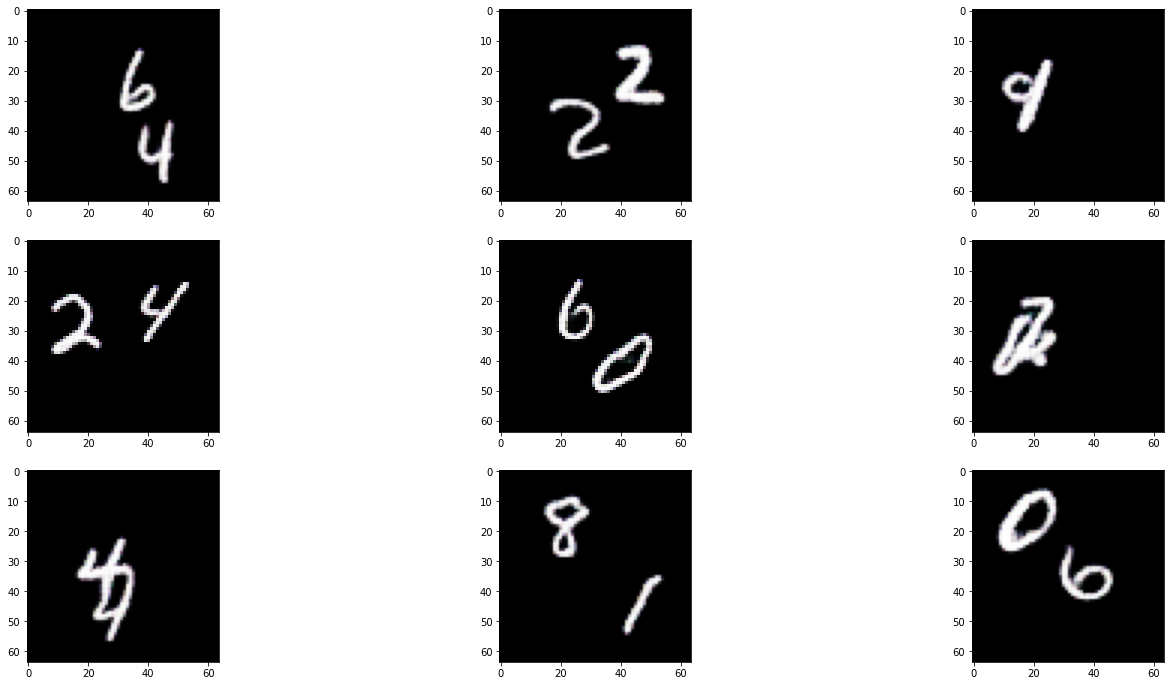

In [21]:
display_images(decoded)
plt.show()